In [110]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

# 0. Dataset Introduction:

- The dataset consists of 208 high definition dynamic 360◦ videos collected from Youtube
- each with at least 4k resolution (3840 pixels in width) and **25 frames per second**. 
- The duration of each video ranges from 20 to 60 seconds.
- latitude and longitude positions **are normalized between 0 and 1** (so they should be multiplied  according to the resolution of the desired  equi-rectangular image output dimension)
- **x and y are the latitude and longitude on a 3D-Sphere**

> Yanyu Xu, Yanbing Dong, Junru Wu, Zhengzhong Sun, Zhiru Shi, Jingyi Yu, and Shenghua Gao: Gaze Prediction in Dynamic 360◦ Immersive Videos. https://github.com/xuyanyu-shh/VR-EyeTracking

**dataset in this project: {person: p001; video: 179; file_name: '179._2017-10-13-10-27_ori_0.txt'}**

In [120]:
import pandas as pd
head = ["frame", "frame_index", "forward", "head_position_x", "head_position_y", 
        "eye", "gaze_position_x", "gaze_position_y"]
df = pd.read_csv('179._2017-10-13-10-27_ori_0.txt',delimiter=",", names = head)
df.head()

,frame,frame_index,forward,head_position_x,head_position_y,eye,gaze_position_x,gaze_position_y
0,frame,1,forward,0.500627,0.527950,eye,0.495522,0.436755
1,frame,2,forward,0.501349,0.528238,eye,0.496338,0.437171
2,frame,3,forward,0.501704,0.528531,eye,0.496785,0.437861
3,frame,4,forward,0.501793,0.528431,eye,0.497054,0.437900
4,frame,5,forward,0.502112,0.528415,eye,0.497443,0.438079


In [121]:
df.corr()

,frame_index,head_position_x,head_position_y,gaze_position_x,gaze_position_y
frame_index,1.000000,0.310022,0.112310,0.268675,0.001620
head_position_x,0.310022,1.000000,-0.061026,0.880373,-0.299595
head_position_y,0.112310,-0.061026,1.000000,-0.115775,0.720481
gaze_position_x,0.268675,0.880373,-0.115775,1.000000,-0.356328
gaze_position_y,0.001620,-0.299595,0.720481,-0.356328,1.000000


# 1. Create Functions

Prediction models for **gaze position** and **head position**

In [111]:
def lr_predict_gaze(hw_x_E,hw_y_E,pw_x_E,pw_y_E, to_predict_head = 'head_position_x'):
    # Use LinearRegression to predict gaze position  
    if to_predict_head == 'head_position_x':
        to_predict_gaze = 'gaze_position_x'
    else:
        to_predict_gaze = 'gaze_position_y'
    reg_E = LinearRegression().fit(hw_x_E,hw_y_E.values.ravel())
    pred_E = pd.DataFrame(reg_E.predict(pw_x_E), columns = [to_predict_gaze])
    MAE_E = mean_absolute_error(pw_y_E, pred_E)
    best_E = None
    return pred_E, MAE_E, best_E;
def mlp_predict_gaze(hw_x_E,hw_y_E,pw_x_E,pw_y_E, to_predict_head = 'head_position_x'):
    # Use MLPRegressor to predict gaze position
    if to_predict_head == 'head_position_x':
        to_predict_gaze = 'gaze_position_x'
    else:
        to_predict_gaze = 'gaze_position_y'
    mlp_parameters = {'hidden_layer_sizes':[(3),(4),(5),(6),(7),(8)]}
    reg_E = MLPRegressor(activation = 'tanh', solver='lbfgs', random_state = 100)
    reg_E = GridSearchCV(estimator=reg_E, param_grid=mlp_parameters, cv=2,
                         scoring='neg_mean_absolute_error', iid=False)
    fit_E = reg_E.fit(hw_x_E,hw_y_E.values.ravel())
    pred_E = pd.DataFrame(fit_E.predict(pw_x_E), columns = [to_predict_gaze])    
    MAE_E = mean_absolute_error(pw_y_E, pred_E)
    best_E = reg_E.best_params_['hidden_layer_sizes']
    return pred_E, MAE_E, best_E;
def lr_predict_head(hw_x_H,hw_y_H,pw_x_H,pw_y_H):
    # Use LinearRegression to predict head position
    reg_H = LinearRegression().fit(hw_x_H,hw_y_H.values.ravel())
    pred_H = reg_H.predict(pw_x_H)    
    MAE_H = mean_absolute_error(pw_y_H, pred_H)
    best_H = None
    return pred_H, MAE_H, best_H;
def mlp_predict_head(hw_x_H,hw_y_H,pw_x_H,pw_y_H):
    # Use MLPRegressor to predict head position
    mlp_parameters = {'hidden_layer_sizes':[(2),(3),(4),(5),(6),(7),(8)]}
    reg_H = MLPRegressor(activation = 'tanh', solver='lbfgs', random_state = 100)
    reg_H = GridSearchCV(estimator=reg_H, param_grid=mlp_parameters, cv=2,
                         scoring='neg_mean_absolute_error', iid=False)
    fit_H = reg_H.fit(hw_x_H,hw_y_H.values.ravel())
    pred_H = fit_H.predict(pw_x_H)
    MAE_H = mean_absolute_error(pw_y_H, pred_H)
    best_H = reg_H.best_params_['hidden_layer_sizes']
    return pred_H, MAE_H, best_H;
  

**Final head position prediction function for a whole video**
- `file_name`: the string path of a dataset
- `hw_length`: number of frames in history window
- `pw_length`: number of frames in prediction window
- `to_predict_head`: to predict latitude or longitude (`'head_position_x'` or `'head_position_y'`)
- `predict_gaze`: the model to predict gaze position (`'lr'` or `'mlp'`)
- `predict_head`: the model to predict head position (`'lr'` or `'mlp'`)
- `gaze`: whether use gaze position as a predictor (`True` or `False`) 

In [112]:

def predict_the_whole_video(file_name, hw_length=15, pw_length=25, to_predict_head = 'head_position_x',
                            predict_gaze="lr", predict_head="lr", gaze = True):
    '''
    hw_length: number of frames in history window
    pw_length: number of frames in prediction window
    to_predict_head: which axis to predict ('head_position_x' or 'head_position_y')
    predict_gaze: the model to predict gaze position ('lr' or 'mlp')
    predict_head: the model to predict head position ('lr' or 'mlp')
    gaze: whether use gaze position as a predictor (True or False) 
    '''
    head = ["frame", "frame_index", "forward", "head_position_x", "head_position_y", 
            "eye", "gaze_position_x", "gaze_position_y"]
    df = pd.read_csv(file_name ,delimiter=",", names = head)
    
    if to_predict_head == 'head_position_x':
        to_predict_gaze = 'gaze_position_x'
    else:
        to_predict_gaze = 'gaze_position_y'
        
    max_hw_start_frame = max(df["frame_index"])-hw_length-pw_length+1
    hw_start_frame = []
    hw_end_frame = []
    pw_start_frame = []
    pw_end_frame = []
    all_MAE_E = []
    all_best_E = []
    all_pred_H = []
    all_MAE_H = [] 
    all_best_H = []
    predict_gaze_reg = []
    predict_head_reg = []
    apply_gaze_data = []
    for i in range(0,max_hw_start_frame):
        if gaze == False:
            pred_E = None
            MAE_E= None
            best_E= None
            apply_gaze_data.append('no')
            predict_gaze_reg.append(predict_gaze)
            # history window and prediction window; 
            # x: independent variable; y: dependent variable; H: To predict head position
            # hw_x_H = df[["frame_index"]][i:i+hw_length]
            hw_x_H = df[["frame_index"]][0:hw_length]
            hw_y_H = df[[to_predict_head]][i:i+hw_length]
            # pw_x_H = df[["frame_index"]][i+hw_length:i+hw_length+pw_length]
            pw_x_H = df[["frame_index"]][hw_length:hw_length+pw_length]
            pw_y_H = df[[to_predict_head]][i+hw_length:i+hw_length+pw_length]
            # predict head position
            if predict_head=="lr":
                predict_head_reg.append('lr')
                pred_H, MAE_H, best_H = lr_predict_head(hw_x_H,hw_y_H,pw_x_H,pw_y_H)
            elif predict_head=="mlp":
                predict_head_reg.append('mlp')
                pred_H, MAE_H, best_H = mlp_predict_head(hw_x_H,hw_y_H,pw_x_H,pw_y_H)
        elif gaze == True:
            apply_gaze_data.append('yes')
            # history window and prediction window
            # x: independent variable; y: dependent variable; E: To predict gaze position
            # hw_x_E = df[["frame_index"]][i:i+hw_length]
            hw_x_E = df[["frame_index"]][0:hw_length]
            hw_y_E = df[[to_predict_gaze]][i:i+hw_length]
            # pw_x_E = df[["frame_index"]][i+hw_length:i+hw_length+pw_length]
            pw_x_E = df[["frame_index"]][hw_length:hw_length+pw_length]
            pw_y_E = df[[to_predict_gaze]][i+hw_length:i+hw_length+pw_length]
            # predict gaze position
            if  predict_gaze=="lr":
                predict_gaze_reg.append('lr')
                pred_E, MAE_E, best_E = lr_predict_gaze(hw_x_E,hw_y_E,pw_x_E,pw_y_E,to_predict_head)
            elif predict_gaze=="mlp":
                predict_gaze_reg.append('mlp')
                pred_E, MAE_E, best_E = mlp_predict_gaze(hw_x_E,hw_y_E,pw_x_E,pw_y_E,to_predict_head)
            # history window and prediction window
            # x: independent variable; y: dependent variable; H: To predict head position
            # hw_x_H = df[["frame_index",to_predict_gaze]][i:i+hw_length]
            hw_x_H = df[["frame_index"]][0:hw_length].reset_index(drop=True)
            hw_x_H[to_predict_gaze] = df[[to_predict_gaze]][i:i+hw_length].reset_index(drop=True)
            hw_y_H = df[[to_predict_head]][i:i+hw_length]
            # pw_x_H = df[["frame_index"]][i+hw_length:i+hw_length+pw_length].reset_index(drop=True)
            pw_x_H = df[["frame_index"]][hw_length:hw_length+pw_length].reset_index(drop=True)
            pw_x_H[to_predict_gaze] = pred_E[to_predict_gaze]
            pw_y_H = df[[to_predict_head]][i+hw_length:i+hw_length+pw_length]
            # predict head position
            if predict_head=="lr":
                predict_head_reg.append('lr')
                pred_H, MAE_H, best_H = lr_predict_head(hw_x_H,hw_y_H,pw_x_H,pw_y_H)
            elif predict_head=="mlp":
                predict_head_reg.append('mlp')
                pred_H, MAE_H, best_H = mlp_predict_head(hw_x_H,hw_y_H,pw_x_H,pw_y_H)
        hw_start_frame.append(i+1)
        hw_end_frame.append(i+hw_length)
        pw_start_frame.append(i+hw_length+1)
        pw_end_frame.append(i+hw_length+pw_length)
        all_MAE_E.append(MAE_E)
        all_best_E.append(best_E)
        all_pred_H.append(pred_H)
        all_MAE_H.append(MAE_H)
        all_best_H.append(best_H)
    result = {'gaze':apply_gaze_data, 
              'hw_start_frame':hw_start_frame, 'hw_end_frame':hw_end_frame, 
              'pw_start_frame':pw_start_frame, 'pw_end_frame':pw_end_frame,
              'MAE_E': all_MAE_E, 'best_size_E':all_best_E, 'predict_gaze':predict_gaze_reg,
              'pred_head_position':all_pred_H, 'MAE_H':all_MAE_H, 'best_size_H':all_best_H, 
              'predict_head':predict_head_reg}
    result = pd.DataFrame.from_dict(result)
    result['best_size_E'] = result['best_size_E'].astype(object)
    result['best_size_H'] = result['best_size_H'].astype(object)
    result['hw_length'] = hw_length
    result['hw_length'] = result['hw_length'].astype(object)
    result['pw_length'] = pw_length
    result['pw_length'] = result['pw_length'].astype(object)
    result['to_predict_head'] = to_predict_head
    
    best_size_summary = result[['best_size_E','best_size_H']].describe()
    MAE_summary = result[['MAE_E','MAE_H']].describe()
    predict_gaze_reg = predict_gaze
    predict_head_reg = predict_head
    return result, best_size_summary, MAE_summary, predict_gaze_reg, predict_head_reg;    

# 2. Prediction

- `file_name`: the string path of a dataset
- `hw_length`: number of frames in history window
- `pw_length`: number of frames in prediction window

> 25 frames per second (25 FPS)

|description|history window|prediction window|
|-----------|--------------|-----------------|
|short|0.05s (2 frames)|0.1s (3 frames)|
|intermediate|0.6s (15 frames)|1.0s (25 frames)|
|long|1.0s (25 frames)|2.0s (50 frames)|

> Tan Xu, Bo Han, and Feng Qian. 2019. **Analyzing Viewport Prediction Under Different VR Interactions**. In The 15th International Conference on emerging Networking EXperiments and Technologies (CoNEXT ’19), December 9–12, 2019, Orlando, FL, USA. ACM, New York, NY, USA, 7 pages. https: //doi.org/10.1145/3359989.3365413

- `to_predict_head`: to predict latitude or longitude (`'head_position_x'` or `'head_position_y'`)
- `predict_gaze`: the model to predict gaze position (`'lr'` or `'mlp'`)
- `predict_head`: the model to predict head position (`'lr'` or `'mlp'`)
- `gaze`: whether use gaze position as a predictor (`True` or `False`)

**When `predict_gaze = 'lr'` and `predict_head = 'lr'` ($x_1$ is head position and $x_1$ is gaze position):**

\begin{equation} \label{eq1}
\begin{split}
y & = a_0+a_1x_1+a_2x_2+\epsilon \\
 & = a_0+a_1x_1+a_2(b_1x_1+b_0+\epsilon)+\epsilon \\
 & = a_0+a_2b_0+(a_1+a_2b_1)x_1+\epsilon \\
 & = c_0+c_1x_1+\epsilon
\end{split}
\end{equation}


### 2.1. Example


In [114]:
file_name = '179._2017-10-13-10-27_ori_0.txt'
hw_length = 15
pw_length = 25
to_predict_head = 'head_position_x'
predict_gaze = 'mlp'
predict_head = 'lr'
gaze = True
result, best_size_summary, MAE_summary, predict_gaze_reg, predict_head_reg = \
    predict_the_whole_video(file_name, hw_length, pw_length, to_predict_head, predict_gaze, predict_head, gaze)
result.head()

,gaze,hw_start_frame,hw_end_frame,pw_start_frame,pw_end_frame,MAE_E,best_size_E,predict_gaze,pred_head_position,MAE_H,best_size_H,predict_head,hw_length,pw_length,to_predict_head
0,yes,1,15,16,40,0.023710,5,mlp,"[0.5030381672764711, 0.5032326688282984, 0.503...",0.003734,None,lr,15,25,head_position_x
1,yes,2,16,17,41,0.025961,7,mlp,"[0.5023676461976786, 0.5025003815117225, 0.502...",0.004372,None,lr,15,25,head_position_x
2,yes,3,17,18,42,0.028970,5,mlp,"[0.5014743097896946, 0.5014873163242766, 0.501...",0.006025,None,lr,15,25,head_position_x
3,yes,4,18,19,43,0.031579,7,mlp,"[0.5003076915484539, 0.5001052839708884, 0.499...",0.009523,None,lr,15,25,head_position_x
4,yes,5,19,20,44,0.032802,7,mlp,"[0.498727240923186, 0.4982491280206209, 0.4977...",0.014677,None,lr,15,25,head_position_x


In [118]:
print(MAE_summary)
print(predict_gaze_reg)
print(predict_head_reg)

             MAE_E        MAE_H
count  1440.000000  1440.000000
mean      0.097627     0.064219
std       0.789589     0.184612
min       0.000675     0.000531
25%       0.017117     0.009325
50%       0.032208     0.019335
75%       0.066385     0.044134
max      26.683946     2.477708
mlp
lr


### 2.2. Make predictions given different conditions

- Makes predictions

In [3]:
file_name = '179._2017-10-13-10-27_ori_0.txt'
hw_length_list = [2,15,25]
to_predict_head_list = ['head_position_x','head_position_y']
predict_gaze_list = ['lr','mlp']
predict_head_list = ['lr','mlp']
gaze_list = [True, False]

i=0
all_result = pd.DataFrame()
for to_predict_head in to_predict_head_list:
    for hw_length in hw_length_list:
        for gaze in gaze_list:
            for predict_gaze in predict_gaze_list:
                for predict_head in predict_head_list:
                    i = i + 1
                    if hw_length == 2:
                        pw_length = 3
                    elif hw_length == 15:
                        pw_length = 25
                    elif hw_length == 25:
                        pw_length = 50
                    result, best_size_summary, MAE_summary, predict_gaze_reg, predict_head_reg = \
                        predict_the_whole_video(file_name, hw_length, pw_length, to_predict_head, 
                                                predict_gaze, predict_head, gaze)
                    result['model_index'] = i
                    result['model_index'] = result['model_index'].astype(object)
                    all_result = all_result.append(result, ignore_index=True)
                                    

- Store results of all models into one dataframe and save it into a csv file

In [4]:
bbb = all_result
bbb = bbb.drop(['pred_head_position'], axis=1)
bbb.to_csv('179_p001_all_result.csv')

# 3. Evaluation 

### 3.1. Import the result dataset

In [77]:
p001_179 = pd.read_csv('179_p001_all_result.csv',delimiter=",")
p001_179 = p001_179.drop(p001_179.columns[0], axis=1)
# p001_179.head()

In [78]:
p001_179['best_size_E'] = p001_179['best_size_E'].astype(object)
p001_179['best_size_H'] = p001_179['best_size_H'].astype(object)
p001_179['hw_length'] = p001_179['hw_length'].astype(object)
p001_179['pw_length'] = p001_179['pw_length'].astype(object)
p001_179['model_index'] = p001_179['model_index'].astype(object)
# p001_179.dtypes

In [79]:
cols = ['model_index','to_predict_head','hw_length','pw_length','predict_gaze','predict_head','gaze',
        'hw_start_frame','hw_end_frame','pw_start_frame','pw_end_frame',
        'MAE_E','best_size_E','MAE_H','best_size_H']
p001_179 = p001_179[cols] 
p001_179.head()

,model_index,to_predict_head,hw_length,pw_length,predict_gaze,predict_head,gaze,hw_start_frame,hw_end_frame,pw_start_frame,pw_end_frame,MAE_E,best_size_E,MAE_H,best_size_H
0,1,head_position_x,2,3,lr,lr,yes,1,2,3,5,0.000876,NaN,0.000923,NaN
1,1,head_position_x,2,3,lr,lr,yes,2,3,4,6,0.000236,NaN,0.000295,NaN
2,1,head_position_x,2,3,lr,lr,yes,3,4,5,7,0.000212,NaN,0.000490,NaN
3,1,head_position_x,2,3,lr,lr,yes,4,5,6,8,0.000048,NaN,0.000074,NaN
4,1,head_position_x,2,3,lr,lr,yes,5,6,7,9,0.004538,NaN,0.000053,NaN


### 3.2. Create Evaluation Table

In [107]:
from scipy import stats

evaluation = p001_179.groupby(['to_predict_head', 'hw_length','pw_length',
                               'predict_head','predict_gaze','gaze','model_index']).agg(
    {
    'MAE_H': ['mean','std','median'],
    'best_size_E': (lambda x: stats.mode(x)[0]),
    'best_size_H': (lambda x: stats.mode(x)[0])
})
evaluation



MAE_H  \
                                                                                    mean   
to_predict_head hw_length pw_length predict_head predict_gaze gaze model_index             
head_position_x 2         3         lr           lr           no   5            0.006472   
                                                              yes  1            0.006472   
                                                 mlp          no   7            0.006472   
                                                              yes  3            0.006469   
                                    mlp          lr           no   6            0.171849   
                                                              yes  2            0.041712   
                                                 mlp          no   8            0.171849   
                                                              yes  4            0.068913   
                15        25        lr           lr           no   13           0.069429   
                                                              yes  9            0.069429   
                                                 mlp          no   15           0.069429   
                                                              yes  11           0.064219   
                                    mlp          lr           no   14           0.075880   
                                                              yes  10           0.065141   
                                                 mlp          no   16           0.075880   
                                                              yes  12           0.061567   
                25        50        lr           lr           no   21           0.139555   
                                                              yes  17           0.139555   
                                                 mlp          no   23           0.139555   
                                                              yes  19           0.127649   
                                    mlp          lr           no   22           0.170819   
                                                              yes  18           0.117046   
                                                 mlp          no   24           0.170819   
                                                              yes  20           0.116381   
head_position_y 2         3         lr           lr           no   29           0.000959   
                                                              yes  25           0.000959   
                                                 mlp          no   31           0.000959   
                                                              yes  27           0.000959   
                                    mlp          lr           no   30           0.142054   
                                                              yes  26           0.029738   
                                                 mlp          no   32           0.142054   
                                                              yes  28           0.102889   
                15        25        lr           lr           no   37           0.012835   
                                                              yes  33           0.012835   
                                                 mlp          no   39           0.012835   
                                                              yes  35           0.012753   
                                    mlp          lr           no   38           0.010854   
                                                              yes  34           0.010835   
                                                 mlp          no   40           0.010854   
                                                              yes  36           0.010693   
                25        50        lr           lr           no   45           0.024189   
                                   

### 3.3. Box plots of MAE_H by different prediction models for head_position_x

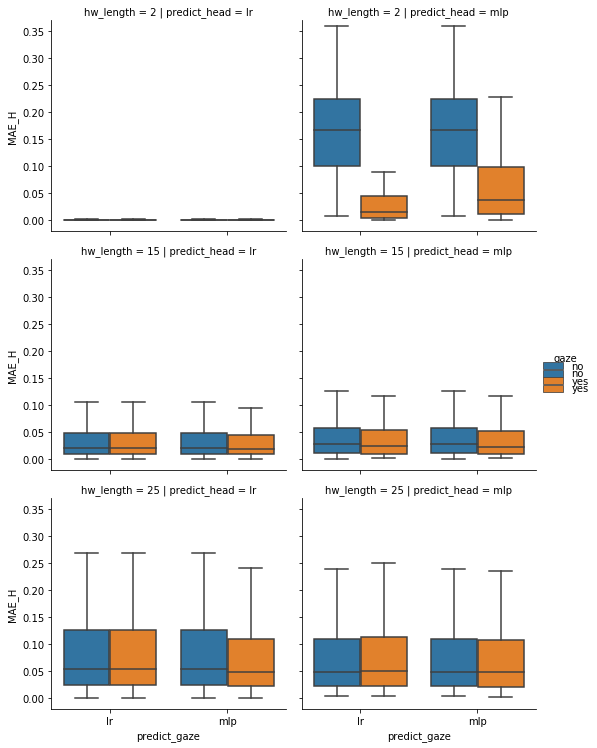

In [124]:
p001_179_x = p001_179[p001_179['to_predict_head'] == 'head_position_x']
gx = sns.catplot(x="predict_gaze", y="MAE_H", hue="gaze", 
                col="predict_head", row="hw_length", hue_order = ['no','yes'],
                data=p001_179_x, kind="box",showfliers = False,
                height=3.5, aspect=1)
gx.add_legend()
gx.set(ylim=(-0.02, 0.37))
gx.savefig("179_p001_x.png")


- Zoom in the first subplot

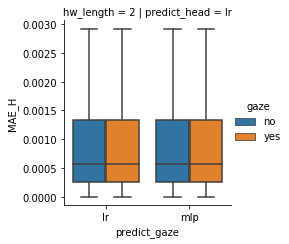

In [108]:
p001_179_x00 = p001_179[p001_179['to_predict_head'] == 'head_position_x']
p001_179_x00 = p001_179_x00[p001_179_x00['predict_head'] == 'lr']
p001_179_x00 = p001_179_x00[p001_179_x00['hw_length'] == 2]
gx00 = sns.catplot(x="predict_gaze", y="MAE_H", hue="gaze", 
                col="predict_head", row="hw_length", hue_order = ['no','yes'],
                data=p001_179_x00, kind="box",showfliers = False,
                height=3.5, aspect=1)
gx00.savefig("179_p001_x00.png")

### 3.3. Box plots of MAE_H by different prediction models for head_position_y

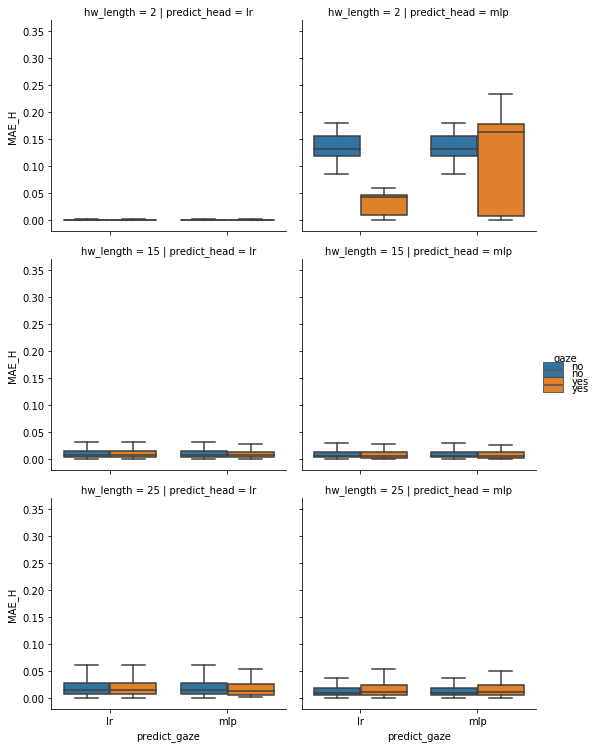

In [125]:
p001_179_y = p001_179[p001_179['to_predict_head'] == 'head_position_y']
gy = sns.catplot(x="predict_gaze", y="MAE_H", hue="gaze", 
                col="predict_head", row="hw_length", hue_order = ['no','yes'],
                data=p001_179_y, kind="box",showfliers = False,
                height=3.5, aspect=1)
gy.add_legend()
gy.set(ylim=(-0.02, 0.37))
gy.savefig("179_p001_y.png")

- Zoom in the first subplot

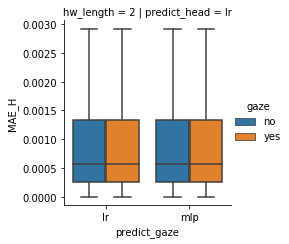

In [109]:
p001_179_y00 = p001_179[p001_179['to_predict_head'] == 'head_position_y']
p001_179_y00 = p001_179_x00[p001_179_x00['predict_head'] == 'lr']
p001_179_y00 = p001_179_x00[p001_179_x00['hw_length'] == 2]
gy00 = sns.catplot(x="predict_gaze", y="MAE_H", hue="gaze", 
                col="predict_head", row="hw_length", hue_order = ['no','yes'],
                data=p001_179_y00, kind="box",showfliers = False,
                height=3.5, aspect=1)
gy00.savefig("179_p001_y00.png")